In [1]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
from theano.tensor.nnet import conv2d
from theano.tensor.signal import downsample
from scipy.io import loadmat
from sklearn.utils import shuffle
from datetime import datetime
%matplotlib inline

/Users/adnguyen/env/tensorflow/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
train = loadmat('../data/svhn/train_32x32.mat')

In [3]:
X_train = train['X']

In [4]:
def display_sample_image(X):
    X = shuffle(X)
    for i in xrange(12):
        plt.subplot(3,4,i)
        plt.imshow(X[:,:,:,i],cmap='gray')
        plt.axis('off')
    plt.plot()

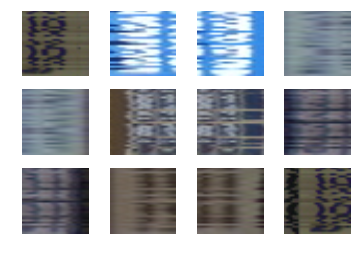

In [5]:
display_sample_image(X_train)

In [6]:
def error_rate(p,t):
    return np.mean(p != t)

In [7]:
def y2indicator(y):
    N = len(y)
    K = len(set(y))
    y_ind = np.zeros((N,K))
    for i in xrange(N):
        y_ind[i,y[i]] = 1
    return y_ind

In [8]:
def init_filter(shape,pool_size):
    w = np.random.randn(*shape) / np.sqrt(np.prod(shape[1:]) + shape[0]*np.prod(shape[2:] / np.prod(pool_size)))
    return w.astype(np.float32)

In [9]:
#rearrange from matlab format to theano format 
#from (W,H,C,N) to (N,C,W,H)
def rearrange(X):
    N = X.shape[-1]
    X_out = np.zeros((N,3,32,32),dtype=np.float32)
    for i in xrange(N):
        for j in xrange(3):
            X_out[i,j,:,:] = X[:,:,j,i]
    return X_out / 255

In [41]:
class CNN(object):
    def __init__(self):
        pass
    def train(self,X,Y,epochs=100,show_fig=True):
        X_train, Y_train = X[:-1000], Y[:-1000]
        X_valid, Y_valid = X[-1000:], Y[-1000:]
        Y_train_ind = y2indicator(Y_train)
        Y_valid_ind = y2indicator(Y_valid)
        N = X_train.shape[0]
        batch_sz = 500
        n_batches = N/batch_sz
        #parameter for full connected layer 
        M = 500
        K = len(set(Y_train))
        costs = []
        best_validation_error = 1
        learning_rate = np.float32(0.00001)
        reg = np.float32(0.01)
        mu = np.float32(0.99)
        pool_size = (2,2)
        w1_init = init_filter((20,3,5,5),pool_size=pool_size)
        b1_init = np.zeros(20,dtype=np.float32)
        w2_init = init_filter((50,20,5,5),pool_size=pool_size)
        b2_init = np.zeros(50,dtype=np.float32)
        w3_init = np.random.randn(w2_init.shape[0]*5*5,M) /np.sqrt(w2_init.shape[0]*5*5 + M)
        b3_init = np.zeros(M,dtype=np.float32)
        w4_init = np.random.randn(M,K) /np.sqrt(M + K)
        b4_init = np.zeros(K,dtype=np.float32)
        self.W1 = theano.shared(w1_init,'w1')
        self.b1 = theano.shared(b1_init,'b1')
        self.W2 = theano.shared(w2_init,'w2')
        self.b2 = theano.shared(b2_init,'b2')
        self.W3 = theano.shared(w3_init.astype(np.float32),'w3')
        self.b3 = theano.shared(b3_init,'b3')
        self.W4 = theano.shared(w4_init.astype(np.float32),'w4')
        self.b4 = theano.shared(b4_init,'b4')
        #momentum change
        dW1 = theano.shared(np.zeros(w1_init.shape,dtype=np.float32),'dW1')
        db1 = theano.shared(np.zeros(b1_init.shape,dtype=np.float32),'db1')
        dW2 = theano.shared(np.zeros(w2_init.shape,dtype=np.float32),'dW2')
        db2 = theano.shared(np.zeros(b2_init.shape,dtype=np.float32),'db2')
        dW3 = theano.shared(np.zeros(w3_init.shape,dtype=np.float32),'dW3')
        db3 = theano.shared(np.zeros(b3_init.shape,dtype=np.float32),'db3')
        dW4 = theano.shared(np.zeros(w4_init.shape,dtype=np.float32),'dW4')
        db4 = theano.shared(np.zeros(b4_init.shape,dtype=np.float32),'db4')
        #place holder for input matrix and target matrix 
        th_X = T.tensor4('X',dtype='float32')
        th_Y = T.matrix('T')
        #feed forward 
        P_Y = self.forward(th_X)
        #define the cost function and prediction 
        params = (self.W1,self.b1,self.W2,self.b2,self.W3,self.b3,self.W4,self.b4)
        reg_cost = reg*np.sum((param*param).sum() for param in params)
        cost = -(th_Y*T.log(P_Y)).sum() + reg_cost
        prediction = T.argmax(P_Y,axis=1)
        #training expression and function 
        update_W1 = self.W1 + mu*dW1 - learning_rate*T.grad(cost,self.W1)
        update_b1 = self.b1 + mu*db1 - learning_rate*T.grad(cost,self.b1)
        update_W2 = self.W2 + mu*dW2 - learning_rate*T.grad(cost,self.W2)
        update_b2 = self.b2 + mu*db2 - learning_rate*T.grad(cost,self.b2)
        update_W3 = self.W3 + mu*dW3 - learning_rate*T.grad(cost,self.W3)
        update_b3 = self.b3 + mu*db3 - learning_rate*T.grad(cost,self.b3)
        update_W4 = self.W4 + mu*dW4 - learning_rate*T.grad(cost,self.W4)
        update_b4 = self.b4 + mu*db4 - learning_rate*T.grad(cost,self.b4)


        #update weight changes 
        update_dW1 = mu*dW1 - learning_rate*T.grad(cost,self.W1)
        update_db1 = mu*db1 - learning_rate*T.grad(cost,self.b1)
        update_dW2 = mu*dW2 - learning_rate*T.grad(cost,self.W2)
        update_db2 = mu*db2 - learning_rate*T.grad(cost,self.b2)
        update_dW3 = mu*dW3 - learning_rate*T.grad(cost,self.W3)
        update_db3 = mu*db3 - learning_rate*T.grad(cost,self.b3)
        update_dW4 = mu*dW4 - learning_rate*T.grad(cost,self.W4)
        update_db4 = mu*db4 - learning_rate*T.grad(cost,self.b4)
        #theano function 
        train = theano.function(
            inputs=[th_X,th_Y],
            updates=[
                (self.W1,update_W1),
                (self.b1,update_b1),
                (self.W2,update_W2),
                (self.b2,update_b2),
                (self.W3,update_W3),
                (self.b3,update_b3),
                (self.W4,update_W4),
                (self.b4,update_b4),
                (dW1,update_dW1),
                (db1,update_db1),
                (dW2,update_dW2),
                (db2,update_db2),
                (dW3,update_dW3),
                (db3,update_db3),
                (dW4,update_dW4),
                (db4,update_db4)
            ]
        )
        get_prediction = theano.function(
            inputs=[th_X,th_Y],
            outputs=[cost,prediction]
        )
        for epoch in xrange(epochs):
            tmp_X, tmp_Y = shuffle(X_train, Y_train_ind)
            for j in xrange(n_batches):
                x = tmp_X[j*batch_sz:(j*batch_sz + batch_sz),:]
                y = tmp_Y[j*batch_sz:(j*batch_sz + batch_sz),:]
                train(x,y)
            if epoch % 10 == 0:
                c,y_val = get_prediction(X_valid,Y_valid_ind)
                costs.append(c)
                e = error_rate(Y_valid,y_val)
                print "Cost / err at iteration i=%d : %.3f / %.3f" % (epoch,c, e)
                if e < best_validation_error:
                        best_validation_error = e
        print "best validation error: ", best_validation_error
        if show_fig:
            plt.plot(costs)
            plt.title('COST')
            plt.show()
    def conv_pool(self,X,W,b,pool_size=(2,2)):
        conv_out = conv2d(input=X,filters=W)
        pool_out = downsample.max_pool_2d(
            input = conv_out,
            ds=pool_size,
            ignore_border = True
        )
        return T.nnet.relu(pool_out + b.dimshuffle('x',0,'x','x'))
    def forward(self,X):
        Z1 = self.conv_pool(X,self.W1,self.b1)
        Z2 = self.conv_pool(Z1,self.W2,self.b2)
        Z2_flat = Z2.flatten(ndim=2)
        Z3 = T.nnet.relu(Z2_flat.dot(self.W3) + self.b3)
        return T.nnet.softmax(Z3.dot(self.W4) + self.b4)
    def predict(self,X):
        P_Y = self.forward(X)
        return T.argmax(P_Y,axis=1)

In [35]:
train = loadmat('../data/svhn/train_32x32.mat')
X_train = rearrange(train['X'])
Y_train = train['y'].flatten() - 1

Cost / err at iteration i=0 : 2198.185 / 0.776
Cost / err at iteration i=10 : 356.233 / 0.104
Cost / err at iteration i=20 : 512.316 / 0.104
Cost / err at iteration i=30 : 701.114 / 0.121
Cost / err at iteration i=40 : 728.250 / 0.105
Cost / err at iteration i=50 : 732.005 / 0.101
Cost / err at iteration i=60 : 695.030 / 0.100
Cost / err at iteration i=70 : 700.765 / 0.102
Cost / err at iteration i=80 : 668.822 / 0.097
Cost / err at iteration i=90 : 641.149 / 0.097
best validation error:  0.097


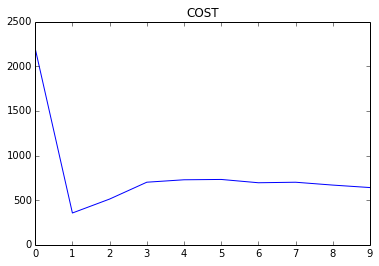

In [38]:
cnn_model = CNN()
cnn_model.train(X_train,Y_train)

In [40]:
Y_train.shape

(73257,)